In [ ]:
!pip install transformers #hugging face

In [ ]:
import warnings
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
from sklearn import preprocessing
from transformers import AutoTokenizer, AutoModel, get_cosine_schedule_with_warmup #hugging face imports

TOKENIZER_PATH = "roberta-base"
TOKENIZER = AutoTokenizer.from_pretrained(TOKENIZER_PATH)
MODEL_PATH = 'distilroberta-base'
ATTRIBUTES_MERGED = ['antagonize' , 'condescending', 'dismissive', 'generalisation',
    'hostile', 'sarcastic', 'unhealthy', 'healthy']
ATTRIBUTES = ['antagonize' , 'condescending', 'dismissive', 'generalisation',
    'hostile', 'sarcastic', 'unhealthy'] #the goal is to detect unhealthy comments, so we will use the unhealthy attribute
HEALTHY_SAMPLE = 5000
MAX_TOKEN_LEN = 128
BATCH_SIZE = 256
NUM_EPOCHS = 21
LEARNING_RATE = 3e-5
WEIGHT_DECAY = 0.001

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

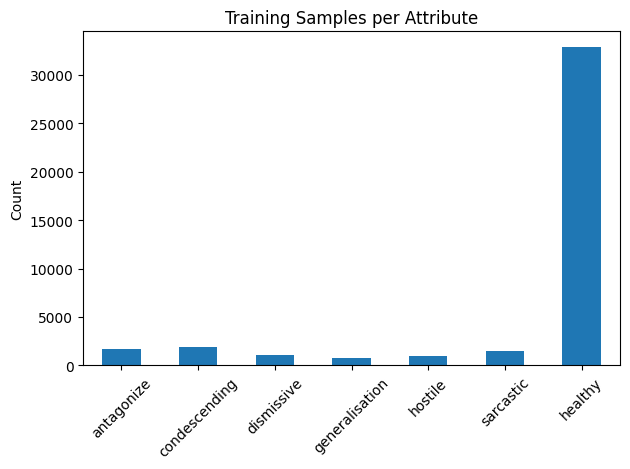

Number of healthy training samples before preprocessing: 32848
Number of unhealthy training samples before preprocessing: 2655


In [ ]:
attributes = [
    'antagonize' , 'condescending', 'dismissive', 'generalisation',
    'hostile', 'sarcastic', 'healthy']

train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
val_data = pd.read_csv('data/val.csv')

train_data[attributes].sum().plot(kind='bar')
plt.title('Training Samples per Attribute')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

healthy_samples = train_data[train_data['healthy'] == 1]
unhealthy_samples = train_data[train_data['healthy'] == 0]

print(f"Number of healthy training samples before preprocessing: {len(healthy_samples)}")
print(f"Number of unhealthy training samples before preprocessing: {len(unhealthy_samples)}")

In [ ]:
#balance training data by removing healthy labels without hurting other attributes
def preprocess_train(train_data):
  healthy_symptomatic = train_data[
      (train_data['healthy'] == 1) &
      (train_data[attributes].sum(axis=1) > 1)
  ]

  healthy_clean = train_data[
      (train_data['healthy'] == 1) &
      (train_data[attributes].sum(axis=1) == 1)
  ]

  unhealthy = train_data[train_data['healthy'] == 0]

  sample_size = len(unhealthy) - len(healthy_symptomatic) + HEALTHY_SAMPLE #need more healthy samples to reflect distribution

  healthy_clean = healthy_clean.sample(n=sample_size, random_state=42)

  balanced_train_data = pd.concat([healthy_symptomatic, healthy_clean, unhealthy])

  #shuffle the dataset
  balanced_train_data = balanced_train_data.sample(frac=1, random_state=42).reset_index(drop=True)

  #add additional unhealthy label for comparitive purposes: https://github.com/conversationai/unhealthy-conversations?tab=readme-ov-file
  balanced_train_data['unhealthy'] = 1 - balanced_train_data['healthy']

  balanced_train_data[ATTRIBUTES_MERGED].sum().plot(kind='bar')
  plt.title('Training Samples per Attribute After Preprocessing')
  plt.ylabel('Count')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

  return balanced_train_data

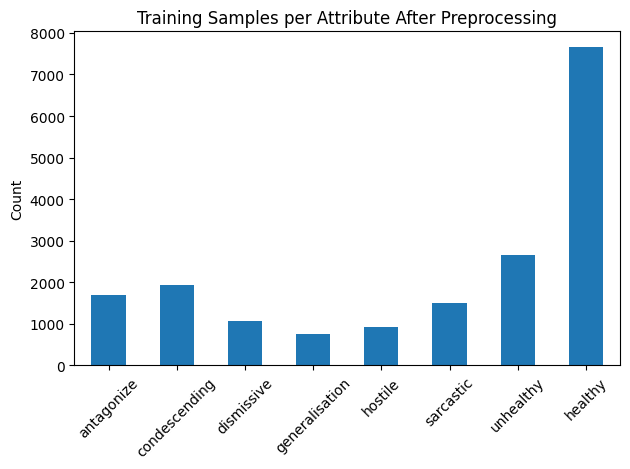

Number of healthy training samples after preprocessing: 7655
Number of unhealthy training samples after preprocessing: 2655


In [ ]:
balanced_train_data = preprocess_train(train_data)
healthy_samples = balanced_train_data[balanced_train_data['healthy'] == 1]
unhealthy_samples = balanced_train_data[balanced_train_data['unhealthy'] == 1]

print(f"Number of healthy training samples after preprocessing: {len(healthy_samples)}")
print(f"Number of unhealthy training samples after preprocessing: {len(unhealthy_samples)}")

In [ ]:
#https://stackoverflow.com/questions/67683406/difference-between-dataset-and-tensordataset-in_pytorch
#Use the format above to implement custom UCC dataset class

class UCC_Dataset(torch.utils.data.Dataset):
  def __init__(self, data):
    self.data = data
    self.tokenizer = TOKENIZER
    self.attributes = ATTRIBUTES
    self.max_token_len = MAX_TOKEN_LEN

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    comment = str(self.data.iloc[idx].comment)
    # Explicitly cast to float to ensure numeric type
    attributes_labels = torch.tensor(self.data.loc[idx, self.attributes].values.astype(float), dtype=torch.float)
#https://huggingface.co/docs/transformers/internal/tokenization_utils#transformers.tokenization_utils_base.PreTrainedTokenizerBase.batch_encode_plus:~:text=tokenize(text)).-,encode_plus,-%3C
    tokenized_comment = self.tokenizer.encode_plus(
        comment,
        add_special_tokens = True,
        padding = 'max_length',
        truncation = True,
        max_length = self.max_token_len,
        return_tensors = 'pt',
        return_attention_mask = True)
    return {
        'input_ids': tokenized_comment['input_ids'].flatten(),
        'attention_mask': tokenized_comment['attention_mask'].flatten(),
        'attributes_labels': attributes_labels
    }

In [ ]:
def load_data(train_data, val_data, test_data, batch_size):
  # Add the 'unhealthy' column to val_data
  val_data['unhealthy'] = 1 - val_data['healthy']
  test_data['unhealthy'] = 1 - test_data['healthy']

  train_ds = UCC_Dataset(train_data)
  val_ds = UCC_Dataset(val_data)
  test_ds = UCC_Dataset(test_data)

  train_loader = torch.utils.data.DataLoader(
      dataset=train_ds,
      batch_size=batch_size,
      num_workers=2,
      pin_memory=True,
      shuffle=True
  )

  test_loader = torch.utils.data.DataLoader(
      dataset=test_ds,
      batch_size=batch_size,
      num_workers=2,
      pin_memory=True,
      shuffle=False
  )

  val_loader = torch.utils.data.DataLoader(
      dataset=val_ds,
      batch_size=batch_size,
      num_workers=2,
      pin_memory=True,
      shuffle=False
  )

  return train_ds, val_ds, train_loader, val_loader, test_loader

In [ ]:
class UCC_classifier(nn.Module):
  def __init__(self):
    super(UCC_classifier, self).__init__()
    self.roBERTa = AutoModel.from_pretrained(MODEL_PATH, return_dict=True)
    self.dropout = nn.Dropout(0.4)
    self.fc = nn.Sequential(
        nn.Linear(self.roBERTa.config.hidden_size, self.roBERTa.config.hidden_size),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(self.roBERTa.config.hidden_size, len(ATTRIBUTES))
    )
    nn.init.xavier_uniform_(self.fc[0].weight)
    nn.init.xavier_uniform_(self.fc[-1].weight)

  def forward(self, input_ids, attention_mask):
    x = self.roBERTa(input_ids=input_ids, attention_mask=attention_mask)
    x = torch.mean(x.last_hidden_state, 1)
    x = self.dropout(x)
    x = self.fc(x)
    return x

In [ ]:
def print_model_size():
  # calculate the model size on disk
  dummy_model = UCC_classifier()
  num_trainable_params = sum([p.numel() for p in dummy_model.parameters() if p.requires_grad])
  param_size = 0
  for param in dummy_model.parameters():
    param_size += param.nelement() * param.element_size()
  buffer_size = 0
  for buffer in dummy_model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()
  size_all_mb = (param_size + buffer_size) / 1024 ** 2
  print(f"model size: {size_all_mb:.2f} MB")

In [ ]:
def evaluate_model(model, val_loader, criterion, device):
  model.eval()
  val_loss = 0
  with torch.no_grad():
      for batch_data in val_loader:
          comments = batch_data['input_ids'].to(device)
          attention_mask = batch_data['attention_mask'].to(device)
          attributes = batch_data['attributes_labels'].to(device)

          outputs = model(comments, attention_mask)
          loss = criterion(outputs, attributes)
          val_loss += loss.item() * comments.size(0)

  val_loss /= len(val_loader.dataset)
  return val_loss

In [18]:
def train_model(model, train_loader, val_loader, num_epochs = NUM_EPOCHS):
  best_auc = 0
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)
  train_loss_per_epoch = []
  val_loss_per_epoch = []

  criterion = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

  scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS,
    pct_start=0.20,
    anneal_strategy='cos',
    div_factor=10.0,
    final_div_factor=100
  )
  '''
  scheduler = get_cosine_schedule_with_warmup(
      optimizer,
      num_warmup_steps=0.2 * num_epochs * len(train_loader),
      num_training_steps=num_epochs * len(train_loader)
  )
  '''

  # Early stopping parameters
  best_val_loss = float('inf')
  patience = 10
  patience_counter = 0
  completed_epochs = 0 # Track the number of completed epochs

  # Gradient clipping
  clipping_value = 0.1 #values to check: [0.01, 0.05, 0.1, 0.5, 1.0]

  # training loop
  for epoch in range(1, num_epochs + 1):
      model.train()  # put in training mode
      running_loss = 0.0
      epoch_time = time.time()
      for batch_data in train_loader:
          inputs = batch_data['input_ids'].to(device)
          attention_mask = batch_data['attention_mask'].to(device)
          labels = batch_data['attributes_labels'].to(device)
          # forward + backward + optimize
          outputs = model(inputs, attention_mask)  # forward pass
          loss = criterion(outputs, labels)  # calculate the loss
          optimizer.zero_grad()  # zero the parameter gradients
          loss.backward()  # backpropagation
          torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value)
          optimizer.step()  # update parameters
          scheduler.step()  # placed here because we are using OneCycleLR

          running_loss += loss.data.item()

      # Normalizing the loss by the total number of train batches
      running_loss /= len(train_loader)
      train_loss_per_epoch.append(running_loss)

      val_loss = evaluate_model(model, val_loader, criterion, device)

      val_loss_per_epoch.append(val_loss)

      completed_epochs = epoch # Update completed_epochs

      model.eval()
      predictions = []
      model.to(device)

      with torch.no_grad():
          for batch_data in test_loader:
              comments = batch_data['input_ids'].to(device)
              attention_mask = batch_data['attention_mask'].to(device)
              outputs = model(comments, attention_mask)
              predictions.extend(outputs.cpu().numpy())

      predictions = np.array(predictions)
      labels = np.array(test_data[ATTRIBUTES])

      # Calculate AUC for each attribute and then the average
      from sklearn import metrics
      auc_scores = []
      for i in range(len(ATTRIBUTES)):
          try:
              auc = metrics.roc_auc_score(labels[:, i].astype(int), predictions[:, i])
              auc_scores.append(auc)
          except ValueError:
              # Handle cases where there's only one class in the labels
              print(f"Could not calculate AUC for attribute {ATTRIBUTES[i]}")
              pass

      average_auc = np.mean(auc_scores) if auc_scores else 0

      if average_auc > best_auc:
          best_auc = average_auc
          patience_counter = 0
          torch.save(model.state_dict(), 'best_model.pth')
      else:
          patience_counter += 1

      if patience_counter >= patience:
          print("Early stopping triggered. Training stopped.")
          break

      log = "Epoch: {} | Train Loss: {:.4f} | Val Loss: {:.4f} | ".format(epoch, running_loss, val_loss)
      epoch_time = time.time() - epoch_time
      log += "Epoch Time: {:.2f} secs".format(epoch_time)
      print(log)


  print('==> Finished Training ...')

  # Plotting Loss
  plt.figure(figsize=(8, 5))
  # Use the actual number of completed epochs for the x-axis
  plt.plot(range(1, completed_epochs + 1), train_loss_per_epoch, label='Train Loss')
  plt.plot(range(1, completed_epochs + 1), val_loss_per_epoch, label='Val Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss Curve')
  plt.legend()

  plt.tight_layout()
  plt.show()

Epoch: 1 | Train Loss: 0.7004 | Val Loss: 0.5014 | Epoch Time: 124.49 secs
Epoch: 2 | Train Loss: 0.5091 | Val Loss: 0.2286 | Epoch Time: 124.71 secs
Epoch: 3 | Train Loss: 0.4204 | Val Loss: 0.2217 | Epoch Time: 124.88 secs
Epoch: 4 | Train Loss: 0.4072 | Val Loss: 0.2105 | Epoch Time: 124.96 secs
Epoch: 5 | Train Loss: 0.3868 | Val Loss: 0.2016 | Epoch Time: 124.96 secs
Epoch: 6 | Train Loss: 0.3720 | Val Loss: 0.1924 | Epoch Time: 119.55 secs
Epoch: 7 | Train Loss: 0.3575 | Val Loss: 0.1867 | Epoch Time: 124.10 secs
Epoch: 8 | Train Loss: 0.3477 | Val Loss: 0.1865 | Epoch Time: 125.06 secs
Epoch: 9 | Train Loss: 0.3357 | Val Loss: 0.1768 | Epoch Time: 119.81 secs
Epoch: 10 | Train Loss: 0.3266 | Val Loss: 0.1609 | Epoch Time: 123.99 secs
Epoch: 11 | Train Loss: 0.3166 | Val Loss: 0.1858 | Epoch Time: 118.41 secs
Epoch: 12 | Train Loss: 0.3057 | Val Loss: 0.1728 | Epoch Time: 118.49 secs
Epoch: 13 | Train Loss: 0.2918 | Val Loss: 0.1986 | Epoch Time: 118.32 secs
Epoch: 14 | Train Los

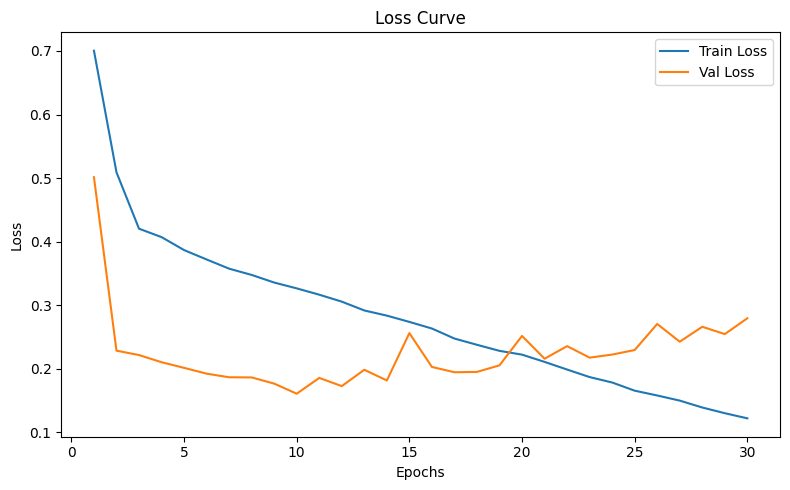

In [ ]:
model = UCC_classifier()
train_ds, val_ds, train_loader, val_loader, test_loader = load_data(balanced_train_data, val_data, test_data, BATCH_SIZE)

train_model(model, train_loader, val_loader)

In [ ]:
labels = np.array(test_data[ATTRIBUTES])

In [ ]:
# Load the best model state dictionary
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

predictions = []
model.to(device)

with torch.no_grad():
    for batch_data in test_loader:
        comments = batch_data['input_ids'].to(device)
        attention_mask = batch_data['attention_mask'].to(device)

        outputs = model(comments, attention_mask)
        predictions.extend(outputs.cpu().numpy())

predictions = np.array(predictions)

Text(0.5, 1.0, 'RoBERTa - Full Fine-Tuning\nROC-AUC Score on Test Set')

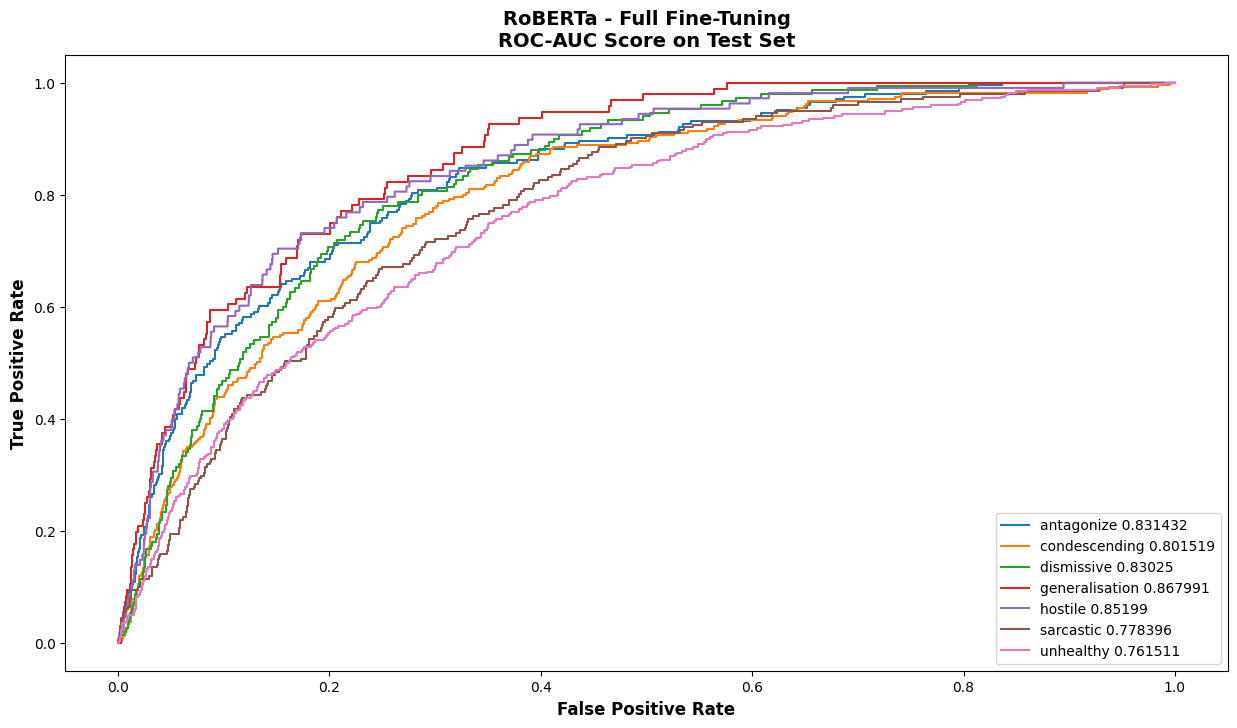

In [ ]:
from sklearn import metrics
plt.figure(figsize=(15, 8))
for i, attribute in enumerate(ATTRIBUTES):
  fpr, tpr, _ = metrics.roc_curve(
      labels[:,i].astype(int), predictions[:, i])
  auc = metrics.roc_auc_score(
      labels[:,i].astype(int), predictions[:, i])
  plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.title("RoBERTa - Full Fine-Tuning\nROC-AUC Score on Test Set", fontsize=14, fontweight='bold')